In [1]:
#RL
from tensorforce import Runner
from tensorforce import Environment
from tensorforce import Agent
#keras
import tensorflow as tf
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
#image processing
from skimage.future import graph
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("Set2")
# skmultiflow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.rules import VeryFastDecisionRulesClassifier
from skmultiflow.trees import ExtremelyFastDecisionTreeClassifier
#scikit 
from scipy.spatial import distance_matrix
#graph
import networkx as nx
#ontology
import owlready2 as owl

In [2]:
%load_ext tensorboard

In [4]:
tf.config.list_physical_devices('GPU')

[]

# help functions

In [3]:
# img = Image.fromarray(States[0], 'RGB')
# img.save("normal.png")
# img.show()

In [4]:
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape[0:2]
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2),
                    (0,0)
                    ),
                  mode = 'constant')

In [5]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (height, width))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [6]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 5:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [7]:
def find_objects(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(3))

    # label image regions
    label_image = label(reg)
    
    return label_image

In [659]:
def find_cut_objects(image,m_h,m_w):
    label_image=find_objects(image)
    regions=regionprops(label_image)
    i=len(regions)-1
    for reg in regions:
        minr, minc, maxr, maxc = reg.bbox
        split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
        split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
        for x in range(int(np.ceil((maxr-minr)/m_h))):
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]][reg.image[split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]]]=i


    regions=regionprops(label_image)
    objects=np.array([to_shape(image[reg.slice],(m_h,m_w)) for reg in regions])
    return label_image, objects, regions

In [810]:
def regions_to_graph(regions,labels,prox=60):
    #weighted?
    centroids=np.array([reg.centroid for reg in regions])
    dist=distance_matrix(centroids,centroids)
    dist=(dist<prox)*dist
    G = nx.from_numpy_matrix(dist)
    lab={x:str(labels[x]) for x in range(len(centroids))}
    nx.set_node_attributes(G, lab, "feature")
    pos_x={x:centroids[x][0] for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_x, "position_x")
    pos_y={x:centroids[x][1] for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_y, "position_y")
    return G

# Enviroment

In [661]:
# OpenAI-Gym environment specification
environment = Environment.create(
       environment='gym', level='SpaceInvaders-v4',max_episode_timesteps=1000)

/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SpaceInvaders-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  logger.warn(


In [662]:
class CustomEnvironment2(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.image_seg=Birch(n_clusters=None,threshold=0.85)
        self.pca_obj=IncrementalPCA(n_components=30)
        self.state_param={}
        self.state_param["type"]="bool"
        self.state_param["shape"]=self.base_env.states()["shape"][0:2]
        #self.state_param["num_values"]=256
        self.example_objects={}
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return self.base_env.actions()

    def preprocess_state(self, state):
        label_image=find_objects(state)
        return label_image>0
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        state=self.preprocess_state(state)
        return state

    def execute(self, actions):
        next_state, terminal, reward = self.base_env.execute(actions)
        
        next_state=self.preprocess_state(next_state)
        
        return next_state, terminal, reward

In [669]:
class CustomEnvironment(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.image_seg=Birch(n_clusters=None,threshold=128,branching_factor=100)
        self.pca_obj=IncrementalPCA(n_components=60)
        self.max_obj_width=160//10
        self.max_obj_height=210//10
        self.state_param={}
        self.state_param["type"]="int"
        self.state_param["shape"]=(self.base_env.states()["shape"][0]//2,self.base_env.states()["shape"][1]//2)
        self.state_param["num_values"]=32
        self.example_objects={}
        self.example_objects_pca={}
        self.iteration=0
        self.keep_train=True
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return self.base_env.actions()

    def preprocess_state(self, state, train=True):
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if train:
            self.pca_obj.partial_fit(np.vstack((X,X)))
            
        X=self.pca_obj.transform(X)
        
        if train:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.state_param["num_values"]-1:
                self.image_seg.set_params(n_clusters=self.state_param["num_values"]-1)
                self.image_seg.partial_fit()
                self.image_seg.labels_=self.image_seg.predict(X)
        else:
            self.image_seg.labels_=self.image_seg.predict(X)
            
        
        for i in range(len(self.image_seg.labels_)):
            if train:
                self.example_objects[self.image_seg.labels_[i]]=state[regions[i].slice]
                self.example_objects_pca[self.image_seg.labels_[i]]=self.pca_obj.inverse_transform(X[i]).reshape(m_h,m_w,3)
            
            label_image[regions[i].slice][regions[i].image]=self.image_seg.labels_[i]+1
        
        label_image=np.max(np.dstack((label_image[0::2,0::2],label_image[1::2,1::2])),axis=-1)
        return label_image.astype("int8"),regions,self.image_seg.labels_
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        state,_,_ = self.preprocess_state(state)
        return state

    def execute(self, actions):
        next_state, terminal, reward = self.base_env.execute(actions)
        
        if self.iteration<500:
            self.iteration+=1
        else:
            self.keep_train=False
        
        next_state,_,_=self.preprocess_state(next_state,self.keep_train)
        
        return next_state, terminal, reward

In [670]:
custom=CustomEnvironment(environment)

# Agent

In [671]:
# PPO agent specification
agent = dict(
    agent='ppo',
    # Automatically configured network
    network='auto',
    # Parameters
    #memory= 1700 ,
    batch_size = 16 , 
    # Reward estimation
    discount=0.95, predict_terminal_values=False,
    reward_processing=None,
    # Baseline network and optimizer
    #baseline=dict(type='auto', size=32, depth=1),
    #baseline_optimizer=dict(optimizer='adam', learning_rate=1e-3, multi_step=10),
    # Regularization
    l2_regularization=0.0, entropy_regularization=0.0,
    # Preprocessing
    state_preprocessing='linear_normalization',
    # Exploration
    exploration=0.0, variable_noise=0.0,
    # Default additional config values
    config=None,
    # Save agent every 10 updates and keep the 5 most recent checkpoints
    saver=dict(directory='model', frequency=10, max_checkpoints=5),
    # Log all available Tensorboard summaries
    summarizer=dict(directory='summaries', summaries='all'),
    # Do record agent-environment interaction trace
    #recorder=dict(directory='record')
)
# or: Agent.create(agent='ppo', environment=environment, ...)
# with additional argument "environment" and, if applicable, "parallel_interactions"

# Initialize the runner
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=1000)

# Train for 200 episodes
runner.run(num_episodes=1)
runner.close()

Episodes:   0%|          | 0/1 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("policy_optimizer/PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("policy_optimizer/PartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("policy_optimizer/PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [887]:
agent = Agent.load(directory='model', format='checkpoint', environment=custom,recorder=dict(directory='record2'))

In [888]:
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=1000)

# Train for 200 episodes
runner.run(num_episodes=1)
runner.close()

Episodes:   0%|          | 0/1 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("policy_optimizer/PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("policy_optimizer/PartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("policy_optimizer/PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [993]:
trace=np.load("./record2/trace-000000000.npz")

States=trace["states"]

In [994]:
States=gray2rgb(States*3).astype(np.uint8)

In [995]:
States

array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[54, 54, 54],
         [54, 54, 54],
         [54, 54, 54],
         ...,
         [54, 54, 54],
         [54, 54, 54],
         [54, 54, 54]],

        [[54, 54, 54],
         [54, 54, 54],
         [54, 54, 54],
         ...,
         [54, 54, 54],
         [54, 54, 54],
         [54, 54, 54]],

        [[54, 54, 54],
         [54, 54, 54],
         [54, 54, 54],
         ...,
         [54, 54, 54],
         [54, 54, 54],
         [54, 54, 54]]],


       [[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0, 

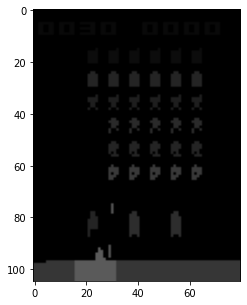

In [971]:
fig = plt.figure(figsize=(5,5))
plt.imshow(States[239])

In [972]:
States.dtype

dtype('uint8')

In [992]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [996]:
make_video(States,name="test2",width=80,height=105,channel=3,fps=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

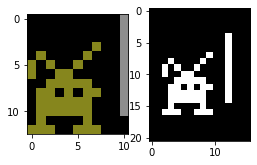

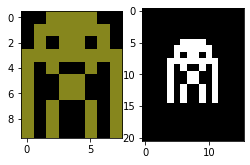

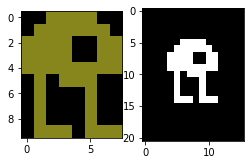

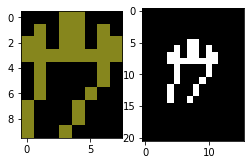

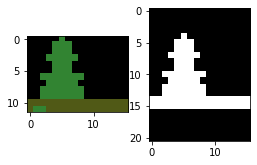

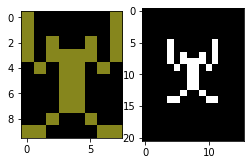

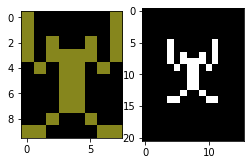

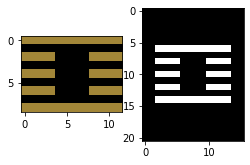

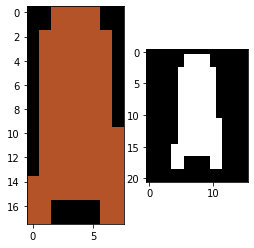

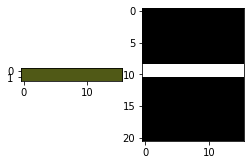

In [27]:
i=0
for k in range(i*10,(i+1)*10):
    fig = plt.figure(figsize=(4,4))
    fig.add_subplot(1,2,1)
    plt.imshow(custom.example_objects[k])
    fig.add_subplot(1,2,2)
    plt.imshow(custom.example_objects_pca[k])

In [29]:
centers=custom.pca_obj.inverse_transform(custom.image_seg.subcluster_centers_).reshape(custom.image_seg.subcluster_centers_.shape[0],210//10,160//10,3)

In [30]:
centers.shape

(255, 21, 16, 3)

In [31]:
np.sum(custom.pca_obj.explained_variance_ratio_[0:40])

0.9995413921551898

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

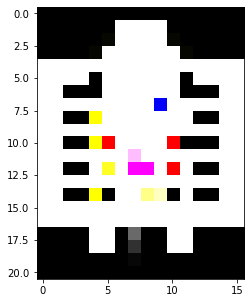

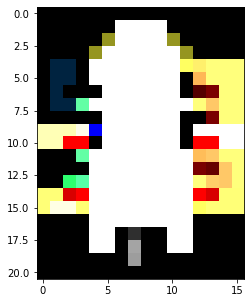

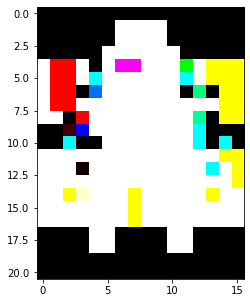

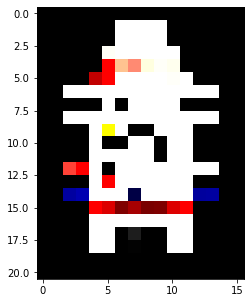

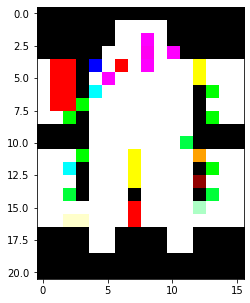

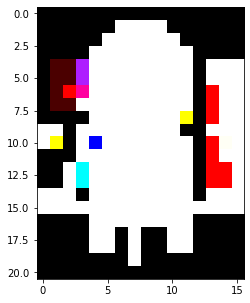

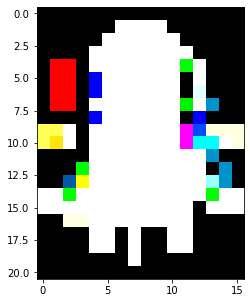

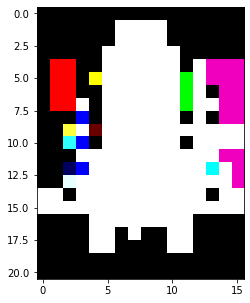

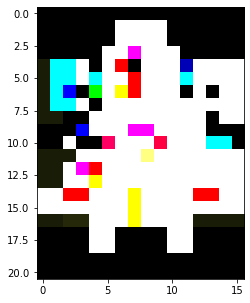

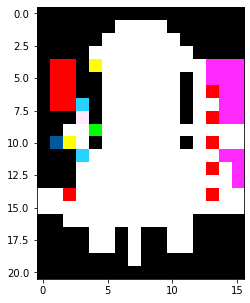

In [32]:
for k in range(i*10,(i+1)*10):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(centers[k])

In [33]:
#%tensorboard --logdir summaries/summary-20220410-201536

# Dimension Reduction

In [509]:
trace=np.load("./record/trace-000000000.npz")

States=trace["states"]

Rewards=trace["reward"]

Actions=trace["actions"]

In [510]:
make_video(States,name="test2")

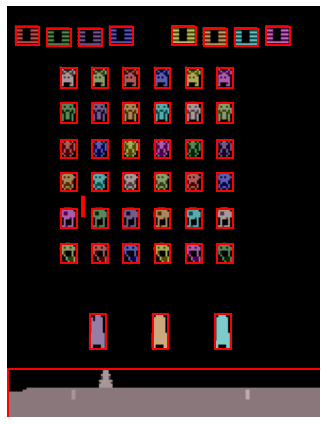

In [511]:
image=States[89]

def find_objects(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(3))

    # label image regions
    label_image = label(reg)
    
    return label_image

label_image=find_objects(image)
visualize_objects(label_image,image)

In [512]:
regions=regionprops(label_image)

In [513]:
m_h=210//10

In [514]:
m_w=160//10

In [515]:
i=len(regions)-1
for reg in regions:
    minr, minc, maxr, maxc = reg.bbox
    split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
    split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
    for x in range(int(np.ceil((maxr-minr)/m_h))):
        for y in range(int(np.ceil((maxc-minc)/m_w))):
            i=i+1
            label_image[reg.slice][split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]][reg.image[split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]]]=i

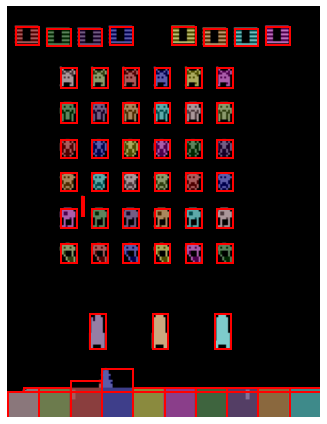

In [516]:
visualize_objects(label_image,image)

In [616]:
regions=regionprops(label_image)

In [617]:
objects=np.array([to_shape(image[reg.slice],(m_h,m_w)) for reg in regions])

In [618]:
X=objects.reshape(objects.shape[0],-1)

In [619]:
regions[3].centroid

(14.0, 137.5)

In [531]:
label_image2=np.zeros(label_image.shape)

In [620]:
objects=np.array([reg.centroid for reg in regions])

In [621]:
objects=np.round(objects).astype("int")

In [533]:
for i in range(len(objects)):
    label_image2[objects[i][0],objects[i][1]]=lab[i]

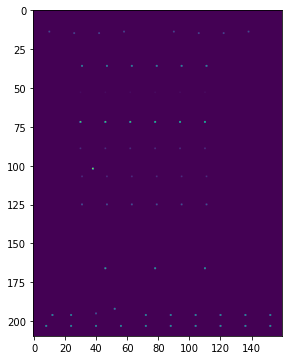

In [534]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label_image2)

In [634]:
G=label_image_to_graph(label_image,lab)

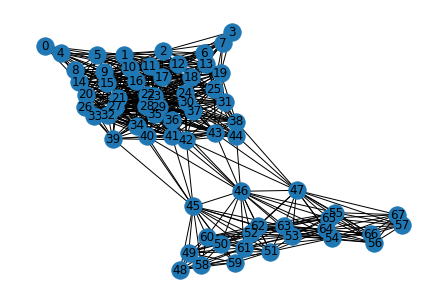

In [639]:
nx.draw(G,with_labels=True)

In [646]:
G2.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67))

In [647]:
G2=G.copy()

In [648]:
G2.remove_node(67)

In [649]:
model = Graph2Vec(attributed=True)
model.fit([G,G2])
X = model.get_embedding()

# Clustering

In [523]:
lab=custom.image_seg.predict(custom.pca_obj.transform(X))

In [524]:
objects.shape

(68, 21, 16, 3)

In [31]:
k=60

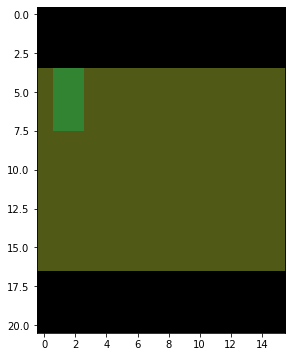

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(objects[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


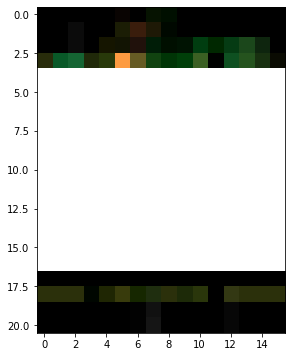

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(custom.pca_obj.inverse_transform(custom.pca_obj.transform(X[k:k+1])).reshape(m_h,m_w,3))

In [34]:
for i in range(len(lab)):
    label_image[regions[i].slice][regions[i].image]=lab[i]+1

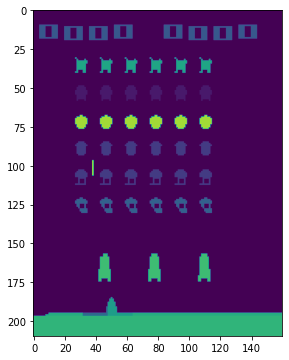

In [497]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label_image)

In [36]:
label_image2=np.max(np.dstack((label_image[0::2,0::2],label_image[1::2,1::2])),axis=-1)

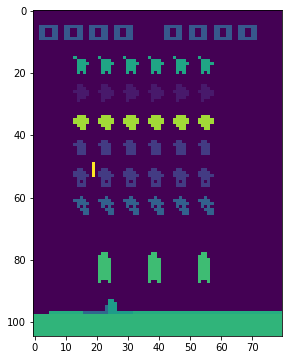

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label_image2)

In [38]:
label_image2.shape

(105, 80)

In [39]:
label_image3=np.max(np.dstack((label_image[0::5,0::5],label_image[1::5,1::5],label_image[2::5,2::5],label_image[3::5,3::5],label_image[4::5,4::5])),axis=-1)

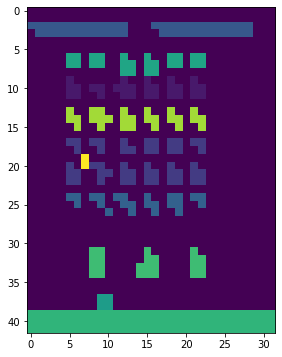

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label_image3)

In [41]:
label_image3.shape

(42, 32)

In [42]:
custom.image_seg.transform(custom.pca_obj.transform(X[k:k+1])).shape

(1, 1239)

/tmp/ipykernel_5276/296060981.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(size, size,i)


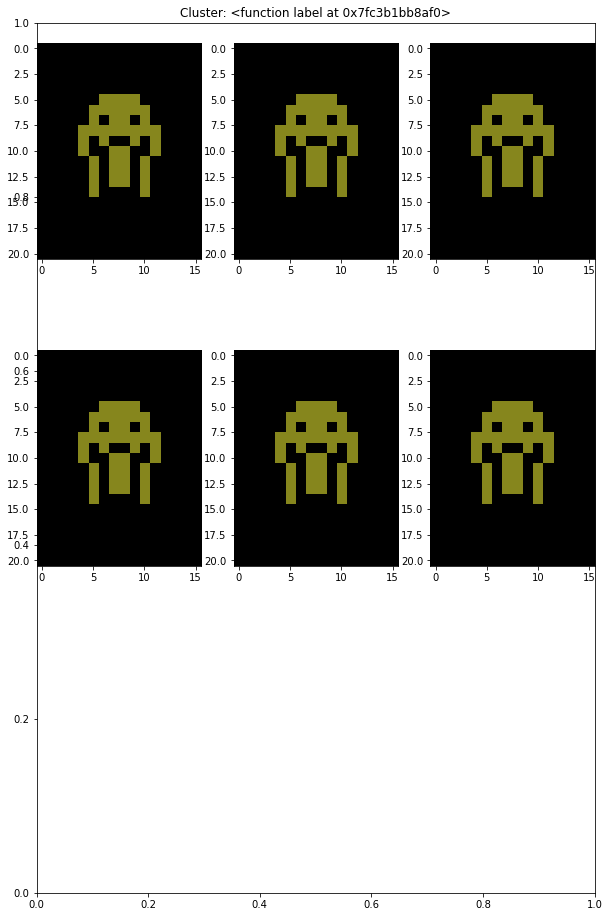

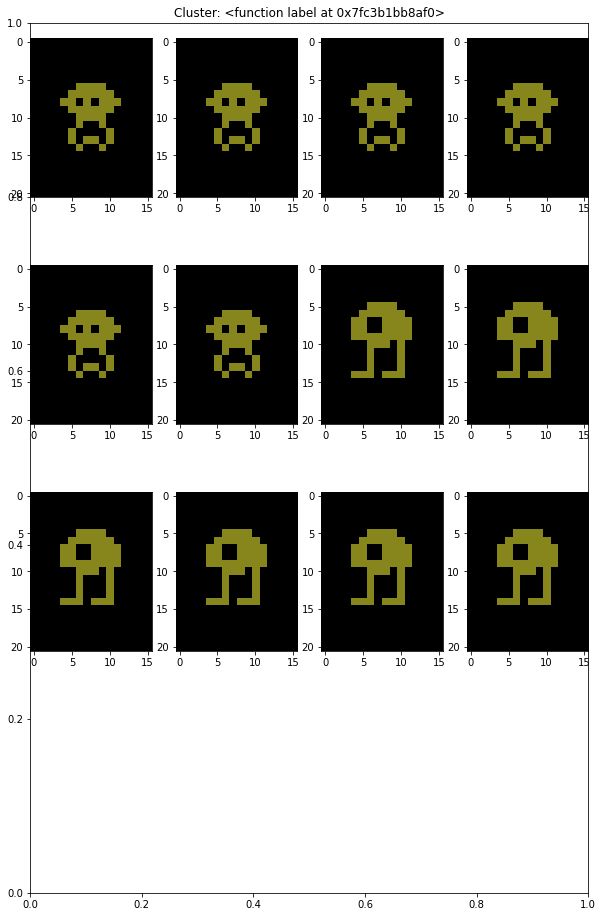

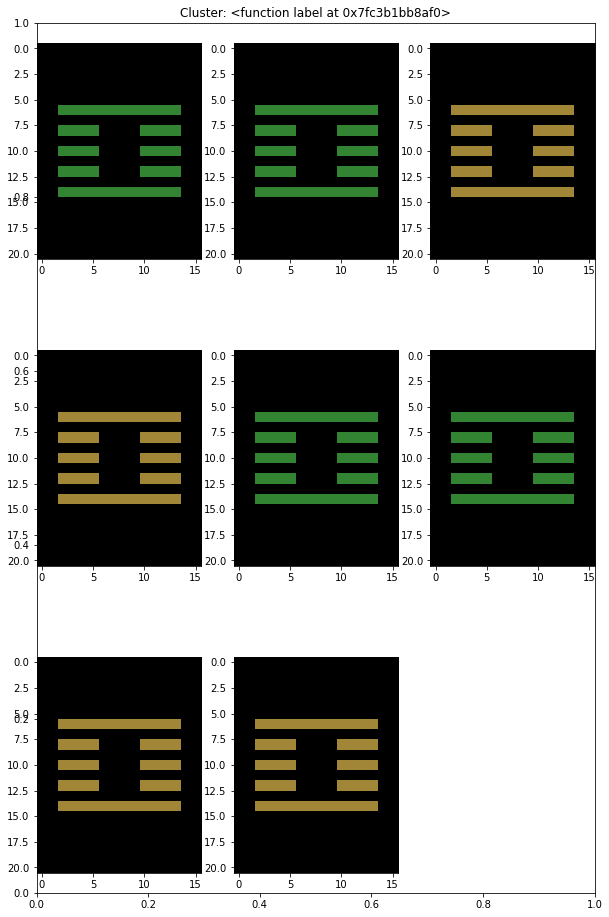

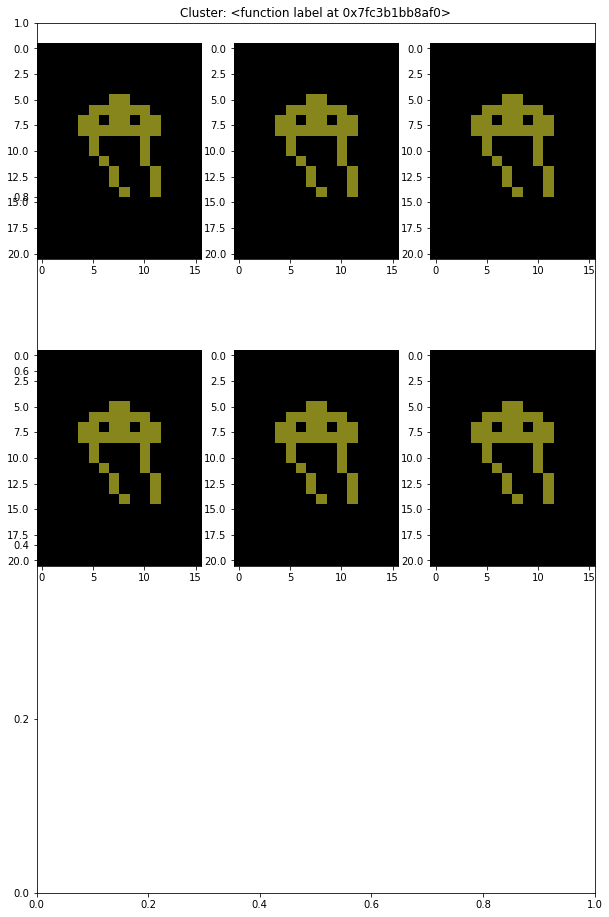

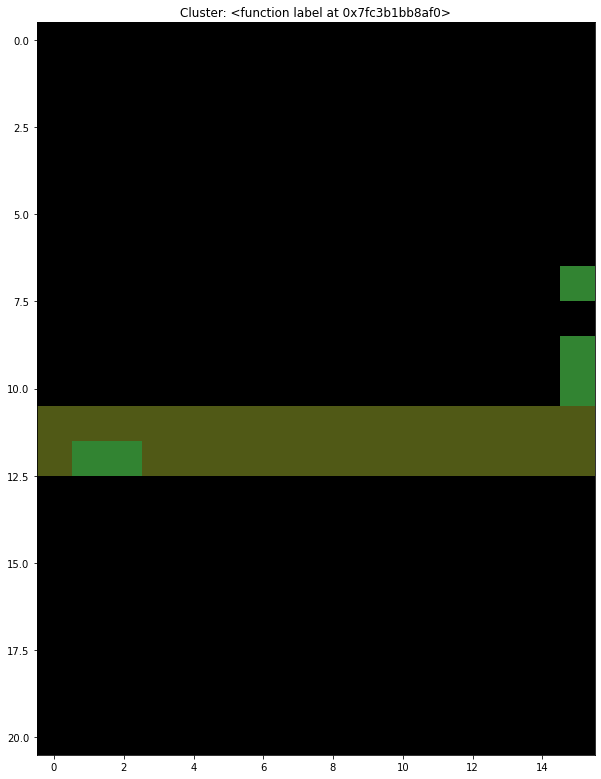

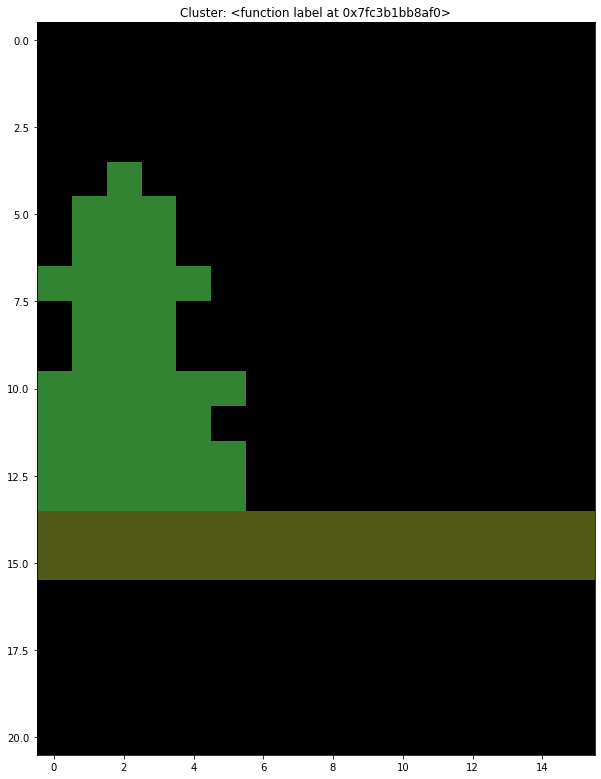

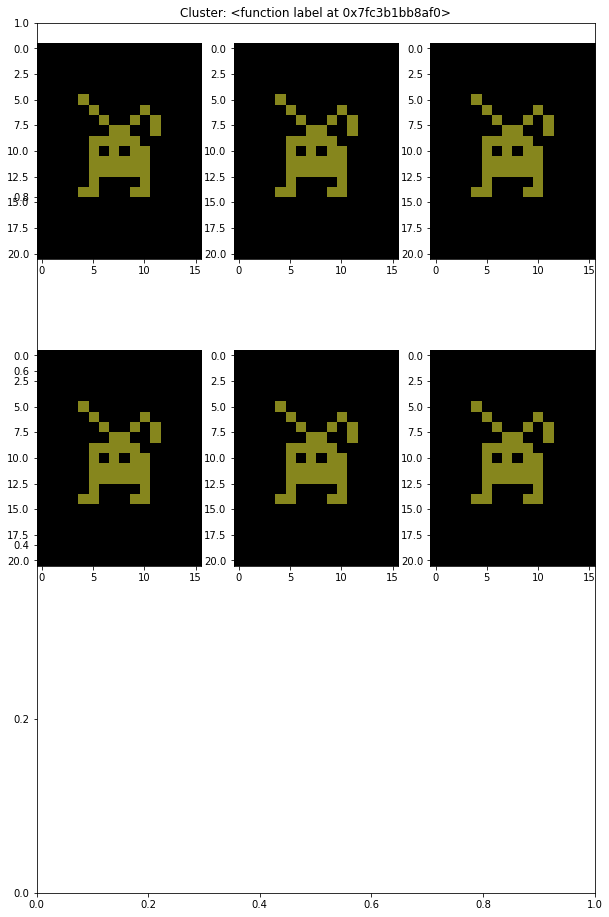

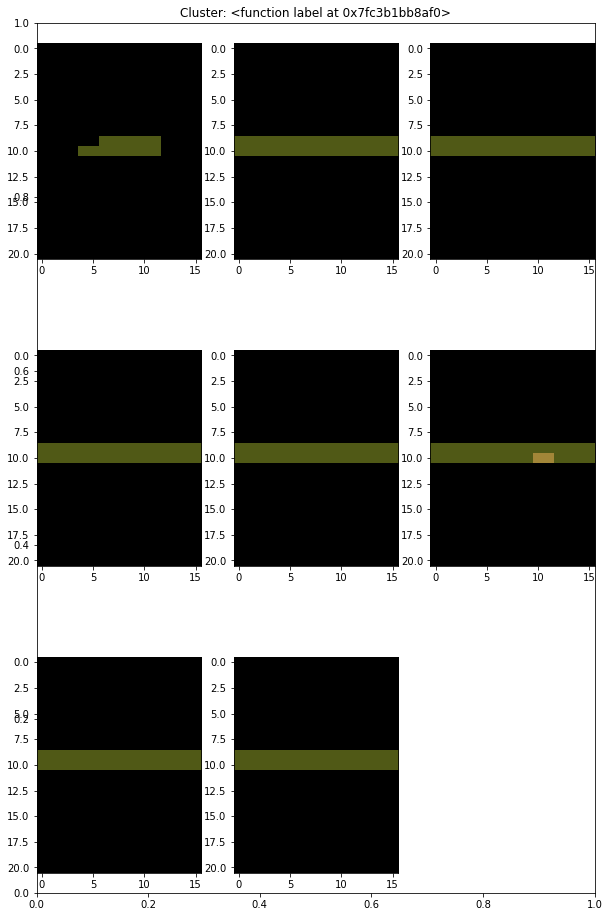

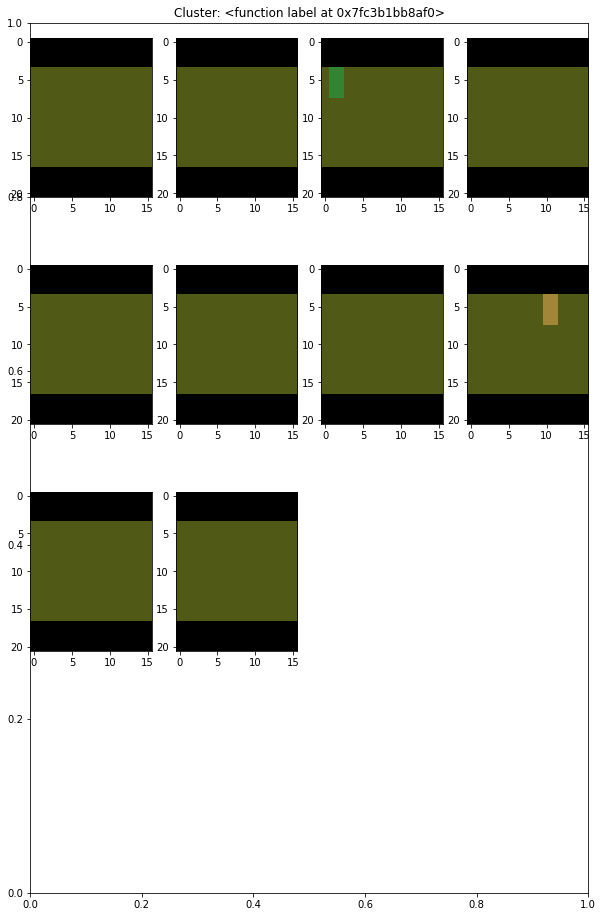

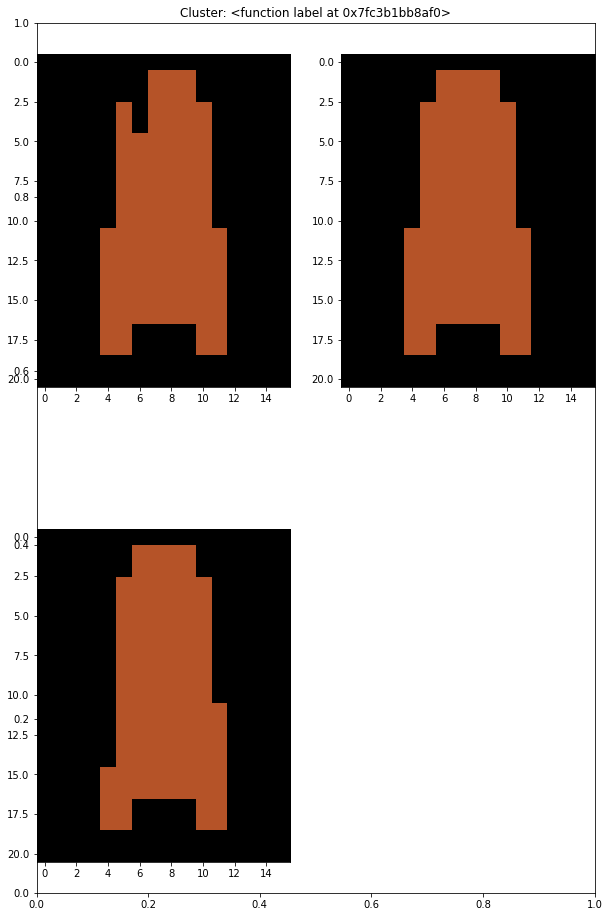

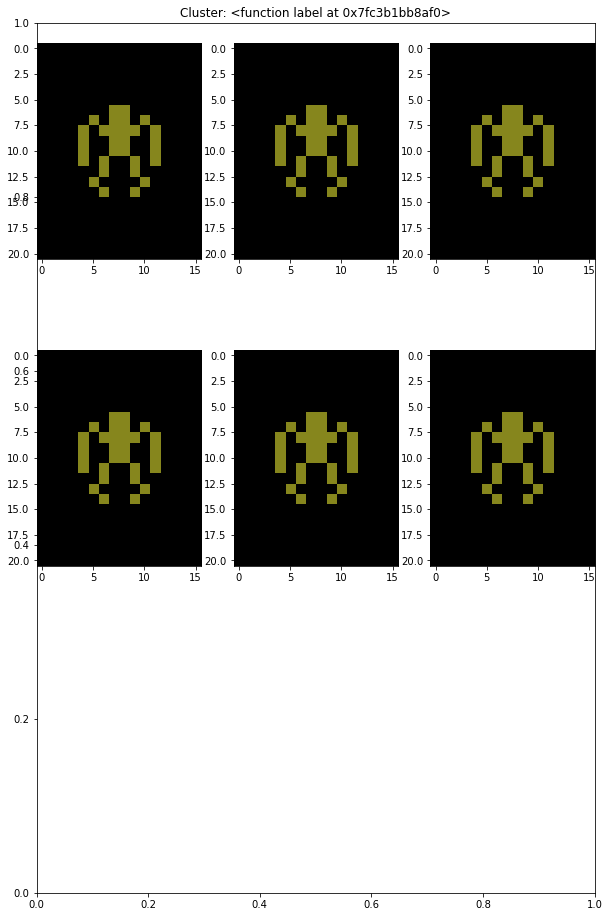

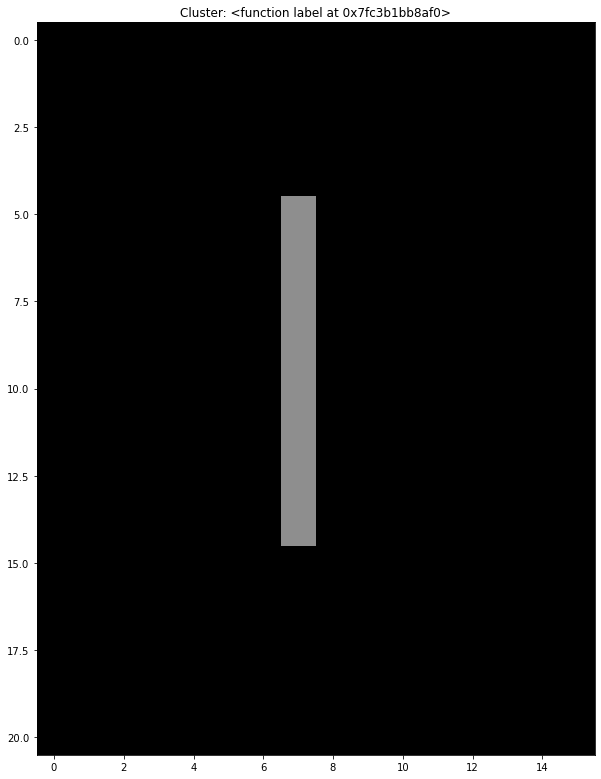

In [43]:
for l in np.unique(lab):
    fig = plt.figure(figsize=(10,16))
    plt.title("Cluster: "+str(label))
    i=1
    size=int(np.ceil(np.sqrt(sum(lab==l))))
    for ob in objects[(lab==l)]:
        fig.add_subplot(size, size,i)
        plt.imshow(ob)
        i+=1

# States Clustering

In [811]:
Graphs=[]
for state in States:
    _,regions,labels=custom.preprocess_state(state, train=False)
    Graphs.append(regions_to_graph(regions,labels))

In [812]:
model = Graph2Vec(attributed=True)
model.fit(Graphs)

In [799]:
model.fit(Graphs[0:3])

In [813]:
X = model.get_embedding()

In [819]:
nx Graphs[0].nodes[0]

{'feature': '13', 'position_x': 14.0, 'position_y': 9.5}

In [822]:
from operator import itemgetter

In [840]:
def knn(graph, node, n):
    return 

In [851]:
G=Graphs[0]

In [869]:
G.edges[0,1]

{'weight': 48.0}

In [854]:
length, path = nx.single_source_dijkstra(G, 0,weight="weight")

In [885]:
path = dict(nx.all_pairs_dijkstra_path(G,weight="weight",cutoff=70))

In [891]:
nodes_near=[x for x in path[0]][1:5]

In [896]:
a=[G.nodes[x]["position_x"] for x in nodes_near]

In [897]:
b=[G.nodes[x]["position_y"] for x in nodes_near]

In [907]:
ind = np.lexsort((b,a))

In [908]:
ind

array([0, 1, 2, 3])

In [909]:
np.array(a)[ind]

array([14.  , 15.  , 15.  , 36.25])

In [910]:
np.array(b)[ind]

array([57.5, 25.5, 41.5, 25.5])

In [803]:
model2 = Graph2Vec(attributed=True)

In [804]:
model2.fit(Graphs[0:3])

In [805]:
X2 = model2.get_embedding()

In [808]:
model.min_count

5

<AxesSubplot:xlabel='x', ylabel='y'>

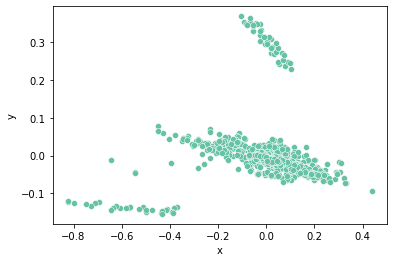

In [815]:
pca = IncrementalPCA(n_components=50)

pca.partial_fit(X)

X = pca.transform(X)

#visualize
df = pd.DataFrame(X[:,:2], columns=["x", "y"])
sns.scatterplot(data=df,x="x",y="y")

In [816]:
np.sum(pca.explained_variance_ratio_)

0.96941286

In [236]:
episode_len=States.shape[0]

In [237]:
obj_mask=np.array([custom.preprocess_state(x, train=False) for x in States])

In [46]:
obj_mask.shape

(795, 105, 80)

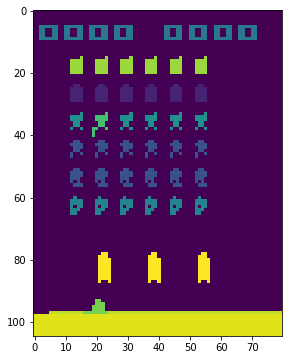

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(obj_mask[60])

<AxesSubplot:xlabel='x', ylabel='y'>

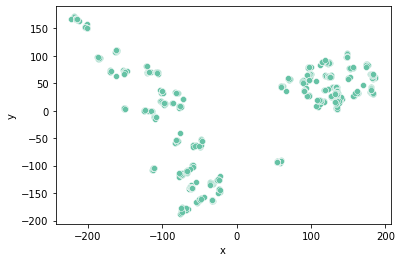

In [59]:
pca = IncrementalPCA(n_components=50)

pca.partial_fit(obj_mask.reshape(episode_len,-1))

X = pca.transform(obj_mask.reshape(episode_len,-1))

#visualize
df = pd.DataFrame(X[:,:2], columns=["x", "y"])
sns.scatterplot(data=df,x="x",y="y")

# X=pca.inverse_transform(X)

# X=X.reshape(obj_mask.shape)

# X=X.astype("uint8")

In [120]:
sum(pca.explained_variance_ratio_[0:49])

0.9463471606057527

In [789]:
brc = Birch(n_clusters=None,threshold=0.08).fit(X)

In [790]:
lab=brc.labels_

In [791]:
np.unique(lab).shape

(31,)

In [792]:
X.shape

(795, 128)

In [793]:
Rewards=trace["reward"]

changes=np.where(lab[1:]!=lab[:-1])[0]

changes=np.concatenate(([0],changes,[len(Rewards)-1]))

In [794]:
changes.shape

(373,)

In [795]:
G=nx.DiGraph()

In [796]:
for c in range(1,len(changes)-1):
    G.add_edge(lab[changes[c]],lab[changes[c+1]], weight=-np.mean(Rewards[changes[c-1]:changes[c]])+100)

G.add_edge(lab[changes[c+1]],-1, weight=-np.mean(Rewards[changes[c]:changes[c+1]])+100)

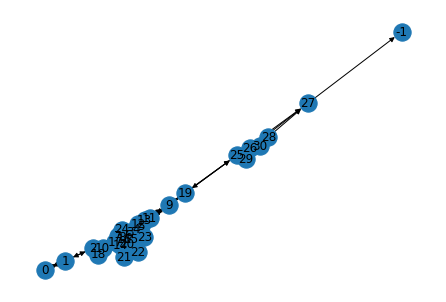

In [797]:
nx.draw(G,with_labels=True)

In [850]:
dist

array([[ 0., 48.,  0., ...,  0.,  0.,  0.],
       [48.,  0., 32., ...,  0.,  0.,  0.],
       [ 0., 32.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., 16., 32.],
       [ 0.,  0.,  0., ..., 16.,  0., 16.],
       [ 0.,  0.,  0., ..., 32., 16.,  0.]])

In [798]:
nx.shortest_path(G, source=0, target=-1, weight="weight", method='dijkstra')

[0, 1, 2, 3, 5, 19, 25, 27, -1]

In [38]:
make_video(States[changes],"test2",fps=7)

# Trees

In [428]:
X=obj_mask

In [429]:
p_h=3
p_w=3
split_h=np.arange(p_h,105-p_h,2).astype("int")
split_w=np.arange(p_w,80-p_w,2).astype("int")

In [430]:
X2=np.zeros((episode_len,len(split_h)*len(split_w),2*p_h+1,2*p_w+1)).astype("int")

In [431]:
position=np.zeros((episode_len,len(split_h)*len(split_w),2))

In [432]:
action=np.zeros((episode_len,len(split_h)*len(split_w),1))

In [433]:
reward=np.zeros((episode_len,len(split_h)*len(split_w),1))

In [434]:
# for i in range(100):
#     j=0
#     for x in range(p_h-1):
#         for y in range(p_w-1):
#             X2[i,j,:,:]=X[i:i+1,split_h[x]:split_h[x+2],split_w[y]:split_w[y+2]]
#             j+=1

In [435]:
for i in range(episode_len):
    j=0
    for x in split_h:
        for y in split_w:
            X2[i,j,:,:]=X[i:i+1,x-p_h:x+p_h+1,y-p_w:y+p_w+1]
            position[i,j,0]=x
            position[i,j,1]=y
            action[i,j,0]=Actions[i]
            reward[i,j,0]=Rewards[i]
            j+=1

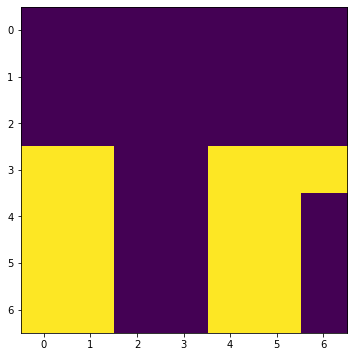

In [436]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(X2[6,68])

In [437]:
X2_prev=X2[0:-2]

X2_now=X2[1:-1]

X2_next=X2[2:]

In [438]:
X2_prev=X2_prev.reshape(-1,2*p_h+1,2*p_w+1).reshape(len(split_h)*len(split_w)*(episode_len-2),-1)

In [439]:
X2_now=X2_prev.reshape(-1,2*p_h+1,2*p_w+1).reshape(len(split_h)*len(split_w)*(episode_len-2),-1)

In [440]:
X2_next=X2_next.reshape(-1,2*p_h+1,2*p_w+1)[:,p_h:p_h+1,p_w:p_w+1].reshape(len(split_h)*len(split_w)*(episode_len-2),)

In [441]:
position_prev=position[0:-2]

position_now=position[1:-1]

position_prev=position_prev.reshape(-1,2)

position_now=position_now.reshape(-1,2)

In [442]:
action_prev=action[0:-2]

action_now=action[1:-1]

action_prev=action_prev.reshape(-1,1)

action_now=action_now.reshape(-1,1)

In [443]:
reward_prev=reward[0:-2]

reward_now=reward[1:-1]

reward_prev=reward_prev.reshape(-1,1)

reward_now=reward_now.reshape(-1,1)

In [444]:
#prev_state positionx positiony action time reward?

In [445]:
nominal_attributes=np.arange(2*X2_prev.shape[1]+2).astype("int")

In [446]:
nominal_attributes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [447]:
state=np.hstack((action_prev,action_now,X2_prev,X2_now,position_now,reward_prev,reward_now))

In [448]:
state.shape

(1467050, 104)

In [394]:
lc_ht = VeryFastDecisionRulesClassifier(nominal_attributes=nominal_attributes)

In [395]:
%time lc_ht.partial_fit(state,X2_next)

CPU times: user 9min 43s, sys: 691 ms, total: 9min 44s
Wall time: 9min 49s


VeryFastDecisionRulesClassifier(drift_detector=None, expand_confidence=1e-07,
                                expand_criterion='info_gain', grace_period=200,
                                max_rules=1000, min_weight=100,
                                nb_prediction=True, nb_threshold=0,
                                nominal_attributes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                ordered_rules=True, remove_poor_atts=False,
                                rule_prediction='first_hit',
                                tie_threshold=0.05)

In [381]:
# lc_ht = HoeffdingTreeClassifier(nominal_attributes=nominal_attributes)

In [382]:
# %time lc_ht.partial_fit(state[::1000],X2_next[::1000])

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.58 s


HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                        leaf_prediction='nba', max_byte_size=33554432,
                        memory_estimate_period=1000000, nb_threshold=0,
                        no_preprune=False,
                        nominal_attributes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                        remove_poor_atts=False, split_confidence=1e-07,
                        split_criterion='info_gain', stop_mem_management=False,
                        tie_threshold=0.05)

In [390]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32)
])

In [391]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [393]:
%time model.fit(state[::1000],X2_next[::1000], epochs=10)

Epoch 1/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2860 - accuracy: 0.9292
Epoch 2/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9469
Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.9564
Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.9680
Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1088 - accuracy: 0.9619
Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0869 - accuracy: 0.9707
Epoch 7/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.9707
Epoch 8/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9796
Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.9775
Epoch 10/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.9809
CPU times: user 1.0

In [397]:
%time Y=lc_ht.predict(state[::1000])

CPU times: user 1.94 s, sys: 4.07 ms, total: 1.94 s
Wall time: 1.94 s


/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/skmultiflow/rules/very_fast_decision_rules.py:837: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(predictions)


In [ ]:
Y

In [ ]:
Y2=X2_next

In [ ]:
np.mean(Y2==Y)

In [ ]:
for x in np.unique(Y2):
    print(str(x)+":"+str(np.mean(Y2[Y2==x]==Y[Y2==x]))+" N:"+str(np.sum(Y2==x)))

In [398]:
print(lc_ht.get_model_description())

Rule 0 :Att (75) = 0.000 and Att (99) = 0.000 and Att (100) <= 84.820 and Att (73) = 17.000| class :0  {0: 9866.0, 10: 2.0, 17: 171.0, 25: 2.0, 31: 1.0}
Rule 1 :Att (75) = 0.000 and Att (67) = 0.000 and Att (69) = 0.000 and Att (101) <= 9.550 and Att (100) <= 11.550 and Att (1) != 5.000| class :0  {0: 3035.0, 8: 8.0}
Rule 2 :Att (100) <= 39.910 and Att (75) = 0.000 and Att (74) = 2.000| class :0  {0: 5585.0, 2: 172.0, 5: 1.0}
Rule 3 :Att (75) = 0.000 and Att (76) = 0.000 and Att (66) = 0.000 and Att (101) <= 16.820 and Att (100) <= 11.360 and Att (0) != 0.000| class :0  {0: 2413.0, 8: 2.0}
Rule 4 :Att (75) = 0.000 and Att (66) = 0.000 and Att (68) != 0.000| class :0  {0: 18615.0, 2: 23.0, 5: 399.0, 8: 6.0, 9: 273.0, 10: 24.0, 14: 1.0, 16: 1.0, 17: 185.0, 18: 1.0, 20: 1.0, 23: 4.0, 25: 261.0, 29: 54.0}
Rule 5 :Att (100) <= 7.910 and Att (75) = 0.000 and Att (67) = 0.000 and Att (101) <= 15.000| class :0  {0: 1359.4968314802538, 8: 2.0}
Rule 6 :Att (75) = 0.000 and Att (82) = 0.000 and A

In [399]:
print(lc_ht.get_rules_description())

AttributeError: 'VeryFastDecisionRulesClassifier' object has no attribute 'get_rules_description'

In [400]:
len(lc_ht.get_model_rules())

21

In [401]:
print(lc_ht.get_model_description())

Rule 0 :Att (75) = 0.000 and Att (99) = 0.000 and Att (100) <= 84.820 and Att (73) = 17.000 | class: 0| class :0  {0: 9866.0, 10: 2.0, 17: 171.0, 25: 2.0, 31: 1.0}
Rule 1 :Att (75) = 0.000 and Att (67) = 0.000 and Att (69) = 0.000 and Att (101) <= 9.550 and Att (100) <= 11.550 and Att (1) != 5.000 | class: 0| class :0  {0: 3035.0, 8: 8.0}
Rule 2 :Att (100) <= 39.910 and Att (75) = 0.000 and Att (74) = 2.000 | class: 0| class :0  {0: 5585.0, 2: 172.0, 5: 1.0}
Rule 3 :Att (75) = 0.000 and Att (76) = 0.000 and Att (66) = 0.000 and Att (101) <= 16.820 and Att (100) <= 11.360 and Att (0) != 0.000 | class: 0| class :0  {0: 2413.0, 8: 2.0}
Rule 4 :Att (75) = 0.000 and Att (66) = 0.000 and Att (68) != 0.000 | class: 0| class :0  {0: 18615.0, 2: 23.0, 5: 399.0, 8: 6.0, 9: 273.0, 10: 24.0, 14: 1.0, 16: 1.0, 17: 185.0, 18: 1.0, 20: 1.0, 23: 4.0, 25: 261.0, 29: 54.0}
Rule 5 :Att (100) <= 7.910 and Att (75) = 0.000 and Att (67) = 0.000 and Att (101) <= 15.000 | class: 0| class :0  {0: 1359.49683148

In [402]:
r=lc_ht.get_model_rules()[2]

In [403]:
r.predicate_set

[Predicate(att_idx=100, operator='<=', value=39.90909090909091),
 Predicate(att_idx=75, operator='=', value=0.0),
 Predicate(att_idx=74, operator='=', value=2.0)]

In [467]:
p_h=3
p_w=3
split_h=np.arange(p_h,105-p_h,1).astype("int")
split_w=np.arange(p_w,80-p_w,1).astype("int")

In [468]:
split_w

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76])

In [469]:
k=500

In [470]:
obj_mask[0]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [19, 19, 19, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19]], dtype=int8)

In [471]:
X2_prev=obj_mask[k:k+1][0]

X2_now=obj_mask[k+1:k+2][0]

X2_next=obj_mask[k+2:k+3][0]

action_prev=Actions[k:k+1][0]

action_now=Actions[k+1:k+2][0]

reward_prev=Rewards[k:k+1][0]

reward_now=Rewards[k+1:k+2][0]

In [472]:
X2_prev.shape

(105, 80)

In [473]:
Y=X2_now.copy()

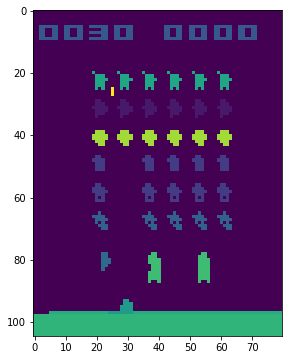

In [474]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(X2_now)

In [475]:
state.shape

(90,)

In [476]:
x

3

In [477]:
y

77

In [478]:
for x in split_h:
    for y in split_w:
        state=np.hstack((action_prev,action_now,X2_prev[x-p_h:x+p_h+1,y-p_w:y+p_w+1].reshape(-1),X2_now[x-p_h:x+p_h+1,y-p_w:y+p_w+1].reshape(-1),np.array([x,y]),reward_prev,reward_now))
        Y[x-p_h:x+p_h+1,y-p_w:y+p_w+1]=lc_ht.predict(state.reshape(1,-1))

In [479]:
np.mean(Y[X2_next!=0]==X2_next[X2_next!=0])

0.45925925925925926

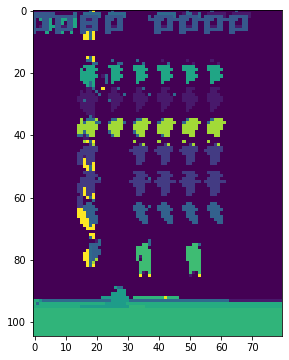

In [480]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(Y)

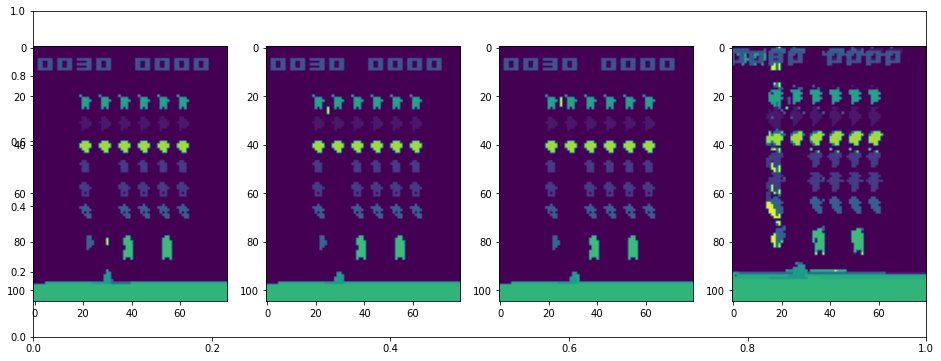

In [481]:
fig, ax = plt.subplots(figsize=(16, 6))
fig.add_subplot(1,4,1)
plt.imshow(X2_prev)
fig.add_subplot(1,4,2)
plt.imshow(X2_now)
fig.add_subplot(1,4,3)
plt.imshow(X2_next)
fig.add_subplot(1,4,4)
plt.imshow(Y)

# Ontology

In [396]:
onto = owl.get_ontology("http://test.org/onto.owl")

In [84]:
onto

get_ontology("http://test.org/onto.owl#")

In [436]:
class State(owl.Thing):
    namespace = onto

In [437]:
class Action(owl.Thing):
    namespace = onto

In [438]:
class from_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [State]
    range  = [Action]

In [439]:
class to_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [Action]
    range  = [State]

In [445]:
with onto:
    class object_representant(owl.DataProperty):
        domain = [Object]
        range = [str]

In [449]:
with onto:
    class object_position_x(owl.DataProperty):
        domain = [Object]
        range = [int]

In [450]:
with onto:
    class object_position_y(owl.DataProperty):
        domain = [Object]
        range = [int]

In [446]:
class Object(owl.Thing):
    namespace = onto

In [460]:
regions[0].bbox

(10, 4, 19, 16)

In [464]:
kmeans.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       0, 0, 0], dtype=int32)

In [466]:
my_object = Object("my_object", namespace = onto, object_representant = ["rep"],object_position_x=[0],object_position_y=[0])

In [467]:
onto.my_object.get_properties()

{einsteins_riddle.object_representant,
 einsteins_riddle.object_position_x,
 einsteins_riddle.object_position_y}

# Reasoning

In [418]:
onto = owl.get_ontology("file://einsteins_riddle.rdf").load()

# Grounding

In [419]:
onto.name

'einsteins_riddle'

In [420]:
list(onto.classes())

[owl.Nothing,
 einsteins_riddle.owl.Beverage,
 einsteins_riddle.owl.Man,
 einsteins_riddle.owl.Color,
 einsteins_riddle.owl.House,
 einsteins_riddle.owl.Pet,
 einsteins_riddle.owl.Cigarette]

In [421]:
list(onto.individuals())

[einsteins_riddle.owl.orange_juice,
 einsteins_riddle.owl.tea,
 einsteins_riddle.owl.water,
 einsteins_riddle.owl.coffee,
 einsteins_riddle.owl.milk,
 einsteins_riddle.owl.Kools,
 einsteins_riddle.owl.Lucky_Strike,
 einsteins_riddle.owl.Parliaments,
 einsteins_riddle.owl.Chesterfields,
 einsteins_riddle.owl.Old_Gold,
 einsteins_riddle.owl.green,
 einsteins_riddle.owl.red,
 einsteins_riddle.owl.blue,
 einsteins_riddle.owl.yellow,
 einsteins_riddle.owl.ivory,
 einsteins_riddle.owl.house-2,
 einsteins_riddle.owl.house-3,
 einsteins_riddle.owl.house-1,
 einsteins_riddle.owl.house-4,
 einsteins_riddle.owl.house-5,
 einsteins_riddle.owl.Ukrainian,
 einsteins_riddle.owl.Spaniard,
 einsteins_riddle.owl.Norwegian,
 einsteins_riddle.owl.Englishman,
 einsteins_riddle.owl.Japanese,
 einsteins_riddle.owl.zebra,
 einsteins_riddle.owl.horse,
 einsteins_riddle.owl.snails,
 einsteins_riddle.owl.dog,
 einsteins_riddle.owl.fox]

In [422]:
list(onto.properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes,
 1.1.description,
 1.1.date,
 1.1.creator]

In [423]:
list(onto.object_properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes]

In [424]:
list(onto.disjoints())

[AllDisjoint([einsteins_riddle.owl.Chesterfields, einsteins_riddle.owl.Englishman, einsteins_riddle.owl.Japanese, einsteins_riddle.owl.Kools, einsteins_riddle.owl.Lucky_Strike, einsteins_riddle.owl.Norwegian, einsteins_riddle.owl.Old_Gold, einsteins_riddle.owl.Parliaments, einsteins_riddle.owl.Spaniard, einsteins_riddle.owl.Ukrainian, einsteins_riddle.owl.blue, einsteins_riddle.owl.coffee, einsteins_riddle.owl.dog, einsteins_riddle.owl.fox, einsteins_riddle.owl.green, einsteins_riddle.owl.horse, einsteins_riddle.owl.house-1, einsteins_riddle.owl.house-2, einsteins_riddle.owl.house-3, einsteins_riddle.owl.house-4, einsteins_riddle.owl.house-5, einsteins_riddle.owl.ivory, einsteins_riddle.owl.milk, einsteins_riddle.owl.orange_juice, einsteins_riddle.owl.red, einsteins_riddle.owl.snails, einsteins_riddle.owl.tea, einsteins_riddle.owl.water, einsteins_riddle.owl.yellow, einsteins_riddle.owl.zebra], ontology = get_ontology("http://persons.iis.nsk.su/files/persons/pages/einsteins_riddle.owl#

In [426]:
with onto:
    owl.sync_reasoner(infer_property_values = True)

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit:/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpwhqkkfrx -Y


* Owlready * Adding relation einsteins_riddle.owl.Norwegian smokes einsteins_riddle.owl.Kools
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian smokes einsteins_riddle.owl.Chesterfields
* Owlready * Adding relation einsteins_riddle.owl.Spaniard smokes einsteins_riddle.owl.Lucky_Strike
* Owlready * Adding relation einsteins_riddle.owl.Englishman smokes einsteins_riddle.owl.Old_Gold
* Owlready * Adding relation einsteins_riddle.owl.Norwegian owns einsteins_riddle.owl.fox
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian owns einsteins_riddle.owl.horse
* Owlready * Adding relation einsteins_riddle.owl.Englishman owns einsteins_riddle.owl.snails
* Owlready * Adding relation einsteins_riddle.owl.Japanese owns einsteins_riddle.owl.zebra
* Owlready * Adding relation einsteins_riddle.owl.Norwegian drinks einsteins_riddle.owl.water
* Owlready * Adding relation einsteins_riddle.owl.Spaniard drinks einsteins_riddle.owl.orange_juice
* Owlready * Adding relation einsteins_riddle

* Owlready2 * HermiT took 1.7078933715820312 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [427]:
query = owl.default_world.prepare_sparql("""SELECT ?house ?man Where{ ?house a einsteins_riddle:House. ?man a einsteins_riddle:Man. ?man einsteins_riddle:lives_in ?house. 
}""")

In [428]:
list(query.execute())

[[einsteins_riddle.owl.house-2, einsteins_riddle.owl.Ukrainian],
 [einsteins_riddle.owl.house-4, einsteins_riddle.owl.Spaniard],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-3, einsteins_riddle.owl.Englishman],
 [einsteins_riddle.owl.house-5, einsteins_riddle.owl.Japanese]]